In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import acf
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [7]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

# cfg.params.stride = 15
# cfg.params.window = 15

cfg.params.stride = 120
cfg.params.window = 5

In [8]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [10]:
cfg.plotting.anesthetic_agent_list = [('anesthesiaLvrOdd', 'ketamine'), ('anesthesiaLvrOdd', 'dexmedetomidine')]

In [ ]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
for data_class, agent in agent_data:
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for dose in ['high', 'low']:
            if dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
                print(f"{agent} | {monkey} | {dose} | {len(agent_data[(data_class, agent)]['session_lists'][monkey][dose])}")

propofol | Mary | high | 10
propofol | MrJones | high | 11
ketamine | SPOCK | high | 8
ketamine | SPOCK | low | 0
ketamine | PEDRI | high | 8
ketamine | PEDRI | low | 0
dexmedetomidine | SPOCK | high | 8
dexmedetomidine | SPOCK | low | 0
dexmedetomidine | PEDRI | high | 8
dexmedetomidine | PEDRI | low | 0


In [17]:
top_percent = 0.1
dose = 'high'
area = 'all'

In [18]:
def get_num_crs(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).sum()
def get_num_crs_pos(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))][x[:int(top_percent*len(x))] >= 0])).sum()

In [19]:
for (data_class, agent), data_dict in agent_data.items():
    print("--------------------------------")
    print(f"{agent}:")
    print("--------------------------------")
    unique_areas = np.unique(np.concatenate([list(d.keys()) for d in data_dict['delase_results'].values()]))
    delase_results = data_dict['delase_results']
    num_crs = {}
    num_crs_pos = {}
    for area in unique_areas:
        print(f"Area: {area}")
        print("---------")
        num_crs[area] = {}
        num_crs_pos[area] = {}
        for session in delase_results.keys():
            if area in delase_results[session].keys():
                num_crs[area][session] = get_num_crs(delase_results, session, top_percent, area)
                num_crs_pos[area][session] = get_num_crs_pos(delase_results, session, top_percent, area)
    
        total_crs = np.sum(list(num_crs[area].values()))
        total_crs_pos = np.sum(list(num_crs_pos[area].values()))
        total_crs_neg = total_crs - total_crs_pos
        print(f"Total CRs: {total_crs}")
        print(f"Positive CRs: {total_crs_pos} ({total_crs_pos/total_crs*100:.2f}%)")
        print(f"Negative CRs: {total_crs_neg} ({total_crs_neg/total_crs*100:.2f}%)")

--------------------------------
propofol:
--------------------------------
Area: all
---------
Total CRs: 209156
Positive CRs: 9942 (4.75%)
Negative CRs: 199214 (95.25%)
--------------------------------
ketamine:
--------------------------------
Area: all
---------
Total CRs: 128023
Positive CRs: 1297 (1.01%)
Negative CRs: 126726 (98.99%)
--------------------------------
dexmedetomidine:
--------------------------------
Area: all
---------
Total CRs: 206042
Positive CRs: 4523 (2.20%)
Negative CRs: 201519 (97.80%)


# Aggregate Plots

In [20]:
area = ['all']

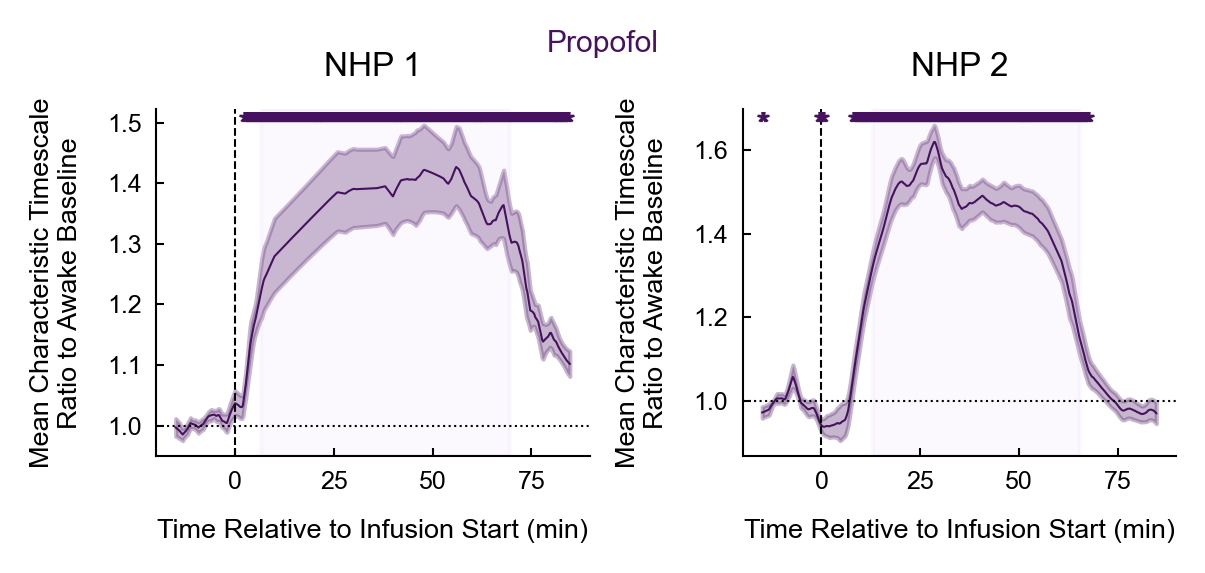

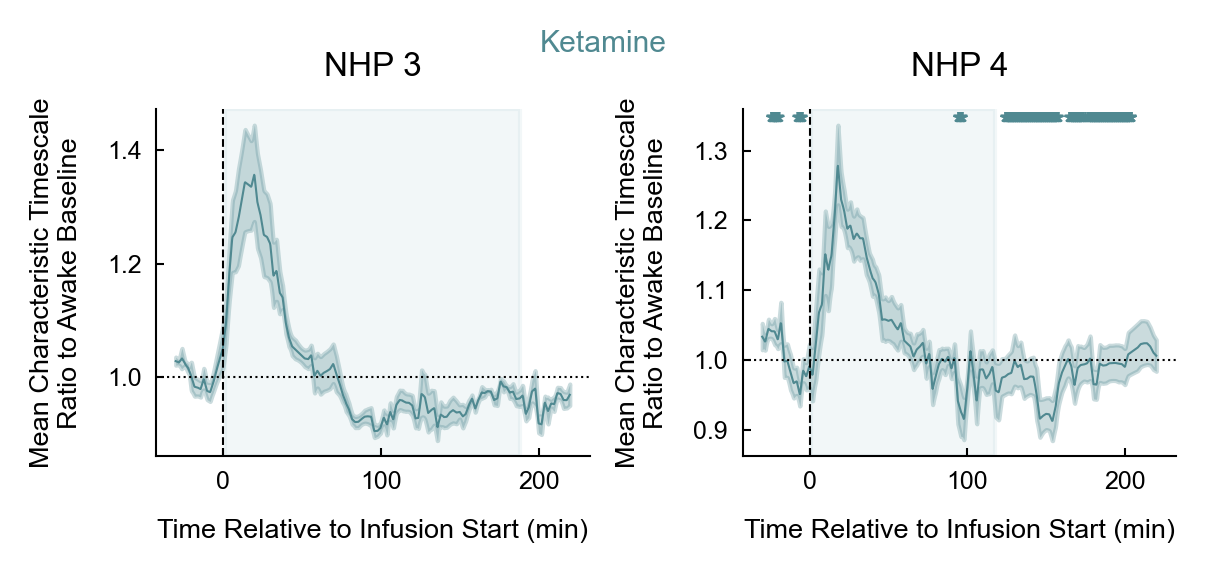

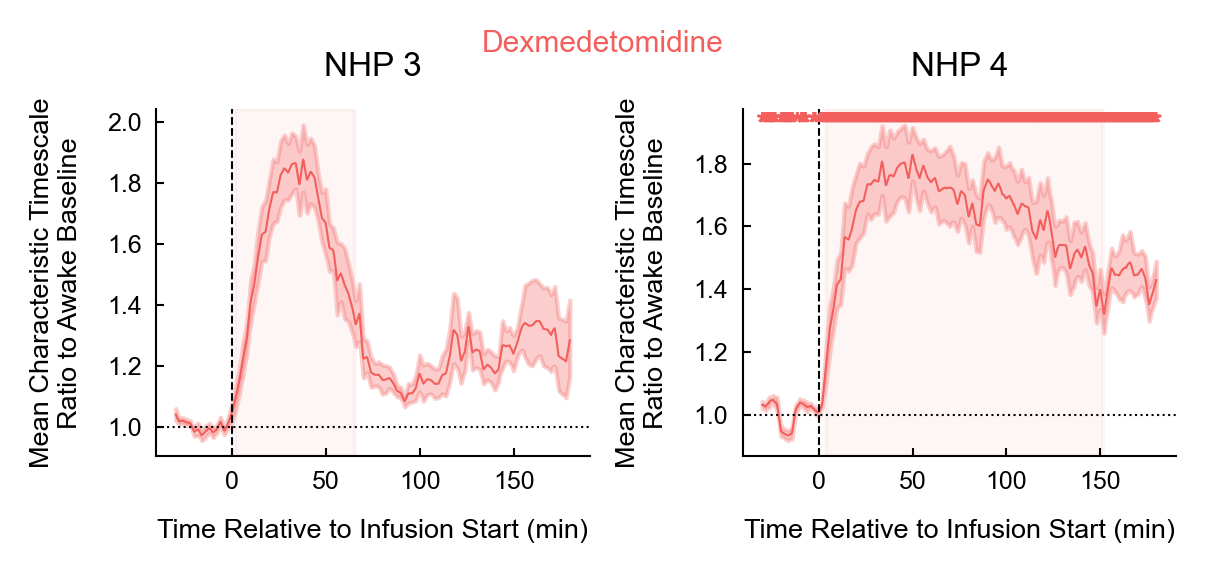

In [21]:
plot_data = {}
for (data_class, agent), data_dict in agent_data.items():
    # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
    # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
    # area = '7b' if agent == 'propofol' else 'dlPFC-R'
    # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    cfg.params.data_class = data_class
    plot_data[(data_class, agent)] = plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=True,
        plot_range=plot_range, 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True,
        area=area,
        return_data=True
    )


propofol high unconscious-awake: 0.001953125
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.03125
ketamine high recovery-awake: 0.015625
ketamine high unconscious-awake: 0.01953125
ketamine high recovery-awake: 0.0078125
dexmedetomidine high unconscious-awake: 0.0078125
dexmedetomidine high unconscious-awake: 0.00390625


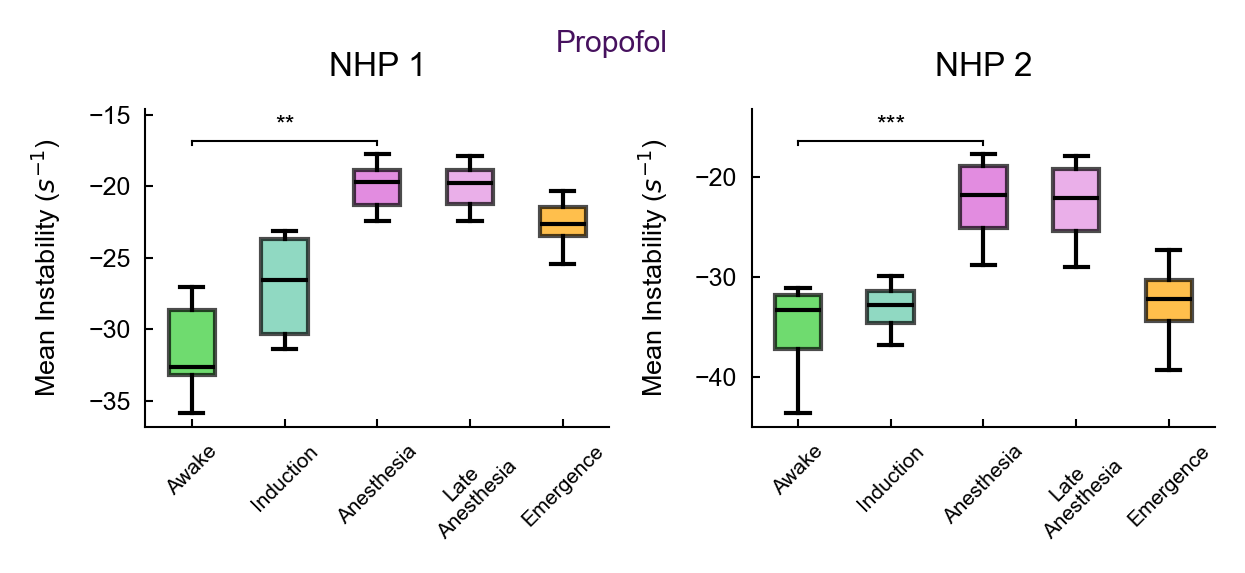

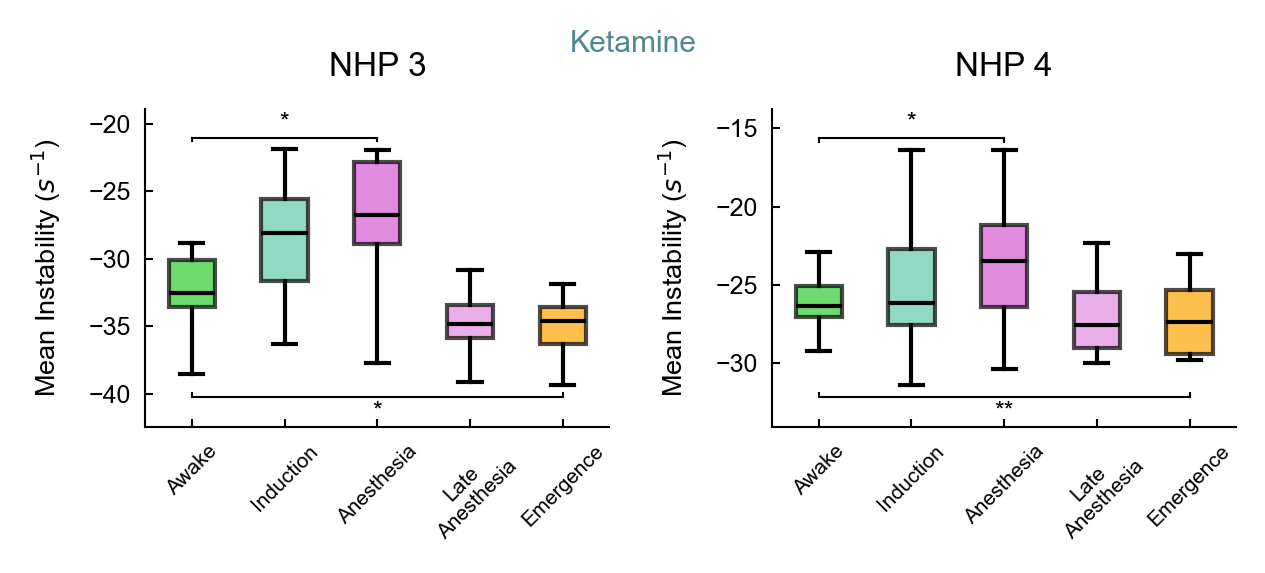

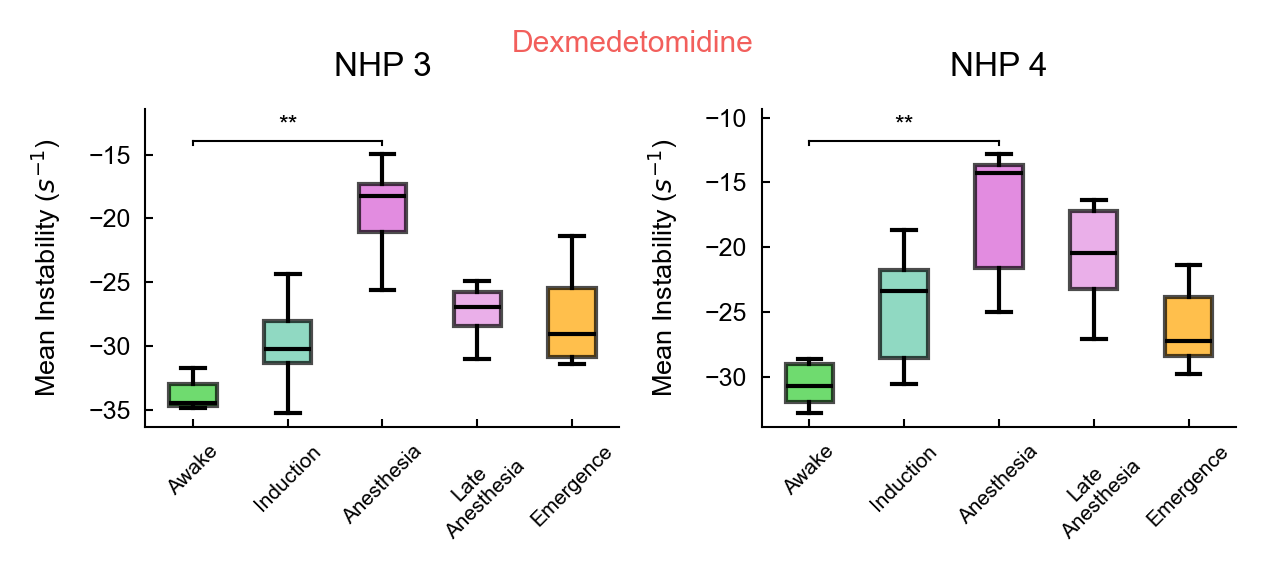

In [23]:
top_percent = 0.1
area = 'all'
section_means = {}
for (data_class, agent), data_dict in agent_data.items():
    # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
    # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
    # area = '7b' if agent == 'propofol' else 'dlPFC-R'
    # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_section_stability_boxes_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_section_stability_boxes_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
    cfg.params.data_class = data_class
    section_means[(data_class, agent)] = plot_section_stability_boxes(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        top_percent=top_percent,
        curve_colors=curve_colors,
        figsize=None,
        dose=dose,
        save_path=save_path,
        section_info_type='plot',
        verbose=False,
        area=area
    )

In [ ]:
# ketamine recovery both monkeys
all_sessions_both = {}
for d in [section_means[('anesthesiaLvrOdd', 'ketamine')][monkey]['high'] for monkey in section_means[('anesthesiaLvrOdd', 'ketamine')].keys()]:
    all_sessions_both.update(d)

In [ ]:
emergence_vals = [all_sessions_both[session]['Emergence'] for session in all_sessions_both.keys()]
awake_vals = [all_sessions_both[session]['Awake'] for session in all_sessions_both.keys()]

In [ ]:
wilcoxon(emergence_vals, awake_vals, alternative='less')

WilcoxonResult(statistic=np.float64(6.0), pvalue=np.float64(0.000213623046875))

# Statistics

### Peak Destabilization Time

In [ ]:
data_class, agent = ('anesthesiaLvrOdd', 'ketamine')
peak_times_ket = {}
for monkey in agent_data[(data_class, agent)]['session_lists']:
    peak_times_ket[monkey] = {}
    sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
    for session in sessions_to_use:
        df = agent_data[(data_class, agent)]['delase_results'][session]['all']
        session_file = h5py.File(os.path.join(cfg.params.all_data_dir, data_class, 'mat', f"{session}.mat"))
        infusion_time = session_file['sessionInfo']['infusionStart'][0, 0]
        df = df[(df.window_start > infusion_time) & (df.window_start < infusion_time + 60*60)]
        peak_time = df.loc[df.stability_params.apply(lambda x: x[:int(0.1*len(x))].mean()).idxmax()].window_start
        
        peak_times_ket[monkey][session] = (peak_time - infusion_time)/60

In [ ]:
data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
peak_times_dex = {}
for monkey in agent_data[(data_class, agent)]['session_lists']:
    peak_times_dex[monkey] = {}
    sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
    for session in sessions_to_use:
        df = agent_data[(data_class, agent)]['delase_results'][session]['all']
        session_file = h5py.File(os.path.join(cfg.params.all_data_dir, data_class, 'mat', f"{session}.mat"))
        infusion_time = session_file['sessionInfo']['infusionStart'][0, 0]
        df = df[(df.window_start > infusion_time) & (df.window_start < infusion_time + 60*60)]
        peak_time = df.loc[df.stability_params.apply(lambda x: x[:int(0.1*len(x))].mean()).idxmax()].window_start
        
        peak_times_dex[monkey][session] = (peak_time - infusion_time)/60

In [ ]:
np.mean(list(peak_times_ket['SPOCK'].values())), np.mean(list(peak_times_dex['SPOCK'].values()))

(np.float64(19.427578194444443), np.float64(38.575431249999994))

In [ ]:
ttest_ind(list(peak_times_ket['SPOCK'].values()), list(peak_times_dex['SPOCK'].values()))

TtestResult(statistic=np.float64(-5.313312496273214), pvalue=np.float64(0.00010949266439349858), df=np.float64(14.0))

In [ ]:
np.mean(list(peak_times_ket['PEDRI'].values())), np.mean(list(peak_times_dex['PEDRI'].values()))

(np.float64(21.748698055555554), np.float64(46.02653159722222))

In [ ]:
ttest_ind(list(peak_times_ket['PEDRI'].values()), list(peak_times_dex['PEDRI'].values()))

TtestResult(statistic=np.float64(-4.657464686747554), pvalue=np.float64(0.0003698108801606008), df=np.float64(14.0))

### Mean Instability Values Across Animals and Sections

In [27]:
mean_values = {}
infusion_starts = {}
top_percents = np.arange(0.01, 0.305, 0.01)
top_percents[9] = 0.1
for data_class, agent in anesthetic_agent_list:
    mean_values[(data_class, agent)] = {}
    infusion_starts[(data_class, agent)] = {}
    cfg.params.data_class = data_class
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        mean_values[(data_class, agent)][monkey] = {}
        infusion_starts[(data_class, agent)][monkey] = {}
        for session in tqdm(sessions_to_use, desc=f'{agent} | {monkey}'):
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            mean_values[(data_class, agent)][monkey][session] = {}
            infusion_starts[(data_class, agent)][monkey][session] = infusion_start
            for top_percent in top_percents:
                mean_values[(data_class, agent)][monkey][session][top_percent] = {}
                for section in ['Awake', 'Anesthesia', 'Emergence']:
                    times_tup = section_info[np.where([tup[0] == section for tup in section_info])[0][0]][1]
                    df_window_starts_rel_minutes = (df.window_start - infusion_start)/60
                    mean_values[(data_class, agent)][monkey][session][top_percent][section] = df[(df_window_starts_rel_minutes >= times_tup[0]) & (df_window_starts_rel_minutes <= times_tup[1])].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).mean()

propofol | Mary:   0%|          | 0/10 [00:00<?, ?it/s]

propofol | MrJones:   0%|          | 0/11 [00:00<?, ?it/s]

In [28]:
monkey_awake_vals = {
    'Mary': [],
    'MrJones': [],
    'SPOCK': [],
    'PEDRI': []
}
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    for monkey in mean_values[(data_class, agent)]:
        monkey_awake_vals[monkey].extend([mean_values[(data_class, agent)][monkey][session][top_percent]['Awake'] for session in mean_values[(data_class, agent)][monkey]])

for monkey in monkey_awake_vals:
    print(f"{monkey} | {np.mean(monkey_awake_vals[monkey])} (+/- {np.std(monkey_awake_vals[monkey])/np.sqrt(len(monkey_awake_vals[monkey]))})")


Mary | -31.3669376373291 (+/- 0.8820038084713956)
MrJones | -35.13462448120117 (+/- 1.264182529990215)
SPOCK | nan (+/- nan)
PEDRI | nan (+/- nan)


/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/_methods.py:210: Runtim

In [29]:
def compute_rank_biserial(a1, a2):
    if isinstance(a1, list):
        a1 = np.array(a1)
    if isinstance(a2, list):
        a2 = np.array(a2)
    diffs = a2 - a1
    pos_diffs = diffs[diffs > 0]
    neg_diffs = diffs[diffs < 0]
    
    w_plus = np.sum(pos_diffs)
    w_minus = np.sum(neg_diffs)

    rank_biserial_correlation = (w_plus - w_minus)/(w_plus + w_minus)
    return rank_biserial_correlation

def matched_pairs_rank_biserial_1d(a1, a2):
    """
    Computes the matched-pairs rank-biserial correlation (r_rb) for 1D arrays.
    
    Parameters
    ----------
    a1 : np.ndarray
        The first 1D array of paired samples.
    a2 : np.ndarray
        The second 1D array of paired samples.

    Returns
    -------
    float
        The rank-biserial correlation coefficient.
    """
    # Ensure inputs are 1D numpy arrays of the same length
    if a1.shape != a2.shape or a1.ndim != 1:
        raise ValueError("Input arrays must be 1D and have the same shape.")

    diff = a2 - a1
    
    # Handle the case where all differences are zero.
    if np.all(diff == 0):
        return 0.0

    # Separate non-zero differences
    non_zero_diff = diff[diff != 0]
    n_non_zero = len(non_zero_diff)
    
    abs_diff = np.abs(non_zero_diff)
    ranks = np.zeros_like(abs_diff, dtype=float)
    sorted_indices = np.argsort(abs_diff)
    
    # Handle ties by assigning average ranks
    current_rank = 1
    i = 0
    while i < n_non_zero:
        j = i
        while j < n_non_zero - 1 and abs_diff[sorted_indices[j]] == abs_diff[sorted_indices[j+1]]:
            j += 1
        
        tie_rank_sum = sum(range(current_rank, current_rank + (j - i + 1)))
        avg_rank = tie_rank_sum / (j - i + 1)
        
        for k in range(i, j + 1):
            ranks[sorted_indices[k]] = avg_rank
        
        current_rank += (j - i + 1)
        i = j + 1
    
    # Calculate W+ and W- using the signed ranks
    w_plus = np.sum(ranks[non_zero_diff > 0])
    w_minus = np.sum(ranks[non_zero_diff < 0])

    # Calculate r_rb using the formula
    if (w_plus + w_minus) == 0:
        return 0.0
    
    return (w_plus - w_minus) / (w_plus + w_minus)

def bootstrap_rank_biserial(a1, a2, B=5000, alpha=0.05):
    if isinstance(a1, list):
        a1 = np.array(a1)
    if isinstance(a2, list):
        a2 = np.array(a2)
    
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    bootstrap_estimates = []
    for _ in range(B):
        sampled_inds = np.random.choice(np.arange(len(a1)), size=len(a1), replace=True)
        # bootstrap_estimates.append(compute_rank_biserial(a1[sampled_inds], a2[sampled_inds]))
        bootstrap_estimates.append(matched_pairs_rank_biserial_1d(a1[sampled_inds], a2[sampled_inds]))
    ci_lower = np.percentile(bootstrap_estimates, lower_percentile)
    ci_upper = np.percentile(bootstrap_estimates, upper_percentile)
    return ci_lower, ci_upper

def compute_wilcoxon_and_rank_biserial(a1, a2, alternative='two-sided', B=5000, alpha=0.05):
    stat, p = wilcoxon(a1, a2, alternative=alternative)
    # rank_biserial_correlation = compute_rank_biserial(a1, a2)
    rank_biserial_correlation = matched_pairs_rank_biserial_1d(a1, a2)
    ci_lower, ci_upper = bootstrap_rank_biserial(a1, a2, B, alpha)
    return {
        'Wilcoxon Statistic': stat,
        'Wilcoxon P-value': p,
        'Rank Biserial Correlation': rank_biserial_correlation,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    }


In [30]:
all_section_means = {}
for data_class, agent in anesthetic_agent_list:
    all_section_means[(data_class, agent)] = {}
    for monkey in mean_values[(data_class, agent)]:
        print(f"{agent} | {monkey}")
        all_section_means[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:
            all_section_means[(data_class, agent)][monkey][top_percent] = {}
            for section in ['Awake', 'Anesthesia', 'Emergence']:
                section_means = [mean_values[(data_class, agent)][monkey][session][top_percent][section] for session in mean_values[(data_class, agent)][monkey]]
                # print(f"{agent} | {monkey} | {section} | {np.mean(section_means)} (+/- {np.std(section_means)/np.sqrt(len(section_means))})")
                all_section_means[(data_class, agent)][monkey][top_percent][section] = section_means

            # awake_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Awake'])
            # anesthesia_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia'])
            # emergence_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Emergence'])

            # wilcoxon_rank_biserial_anesthesia_awake = compute_wilcoxon_and_rank_biserial(awake_means, anesthesia_means, alternative='less')
            # if agent == 'ketamine':
            #     alternative = 'greater'
            # else:
            #     alternative = 'less'
            # wilcoxon_rank_biserial_emergence_awake = compute_wilcoxon_and_rank_biserial(awake_means, emergence_means, alternative=alternative)
            
            # print(f"Anesthesia v Awake")
            # print(f"P-value: {wilcoxon_rank_biserial_anesthesia_awake['Wilcoxon P-value']:.3f}, Rank Biserial Correlation: {wilcoxon_rank_biserial_anesthesia_awake['Rank Biserial Correlation']:.3f}, 95% CI: [{wilcoxon_rank_biserial_anesthesia_awake['95% CI Lower']:.3f}, {wilcoxon_rank_biserial_anesthesia_awake['95% CI Upper']:.3f}]")
            # print(f"Emergence v Awake")
            # print(f"P-value: {wilcoxon_rank_biserial_emergence_awake['Wilcoxon P-value']:.3f}, Rank Biserial Correlation: {wilcoxon_rank_biserial_emergence_awake['Rank Biserial Correlation']:.3f}, 95% CI: [{wilcoxon_rank_biserial_emergence_awake['95% CI Lower']:.3f}, {wilcoxon_rank_biserial_emergence_awake['95% CI Upper']:.3f}]")
            # print("\n")

propofol | Mary
propofol | MrJones


In [31]:
# COMBINED MODELS
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

statistical_info = {}

top_percent = 0.1

for data_class, agent in anesthetic_agent_list:
    statistical_info[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        statistical_info[(data_class, agent)][monkey] = {}
        
        awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
        anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
        emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']

        # Create the data
        data = {
            'session': np.concatenate(([f"S{i+1}" for i in np.arange(len(awake_means))], [f"S{i+1}" for i in np.arange(len(anesthesia_means))], [f"S{i+1}" for i in np.arange(len(emergence_means))])),
            'session_order': np.concatenate((np.arange(len(awake_means)), np.arange(len(anesthesia_means)), np.arange(len(emergence_means)))),
            'state':  ['Awake']*len(awake_means) + ['Anesthesia']*len(anesthesia_means) + ['Emergence']*len(emergence_means),
            'instability': np.concatenate((awake_means, anesthesia_means, emergence_means))
        }
        df = pd.DataFrame(data)
        statistical_info[(data_class, agent)][monkey]['df'] = df
    
        # --- Define Formulas ---
        # Explicitly setting 'Awake' as the reference for all models
        BASE_STATE_FORMULA = "instability ~ C(state, Treatment(reference='Awake'))"
        # Formula 1: Simple OLS
        FORMULA_OLS = BASE_STATE_FORMULA
        # Formula 2: LMEM (Clustering Control)
        FORMULA_LMEM = BASE_STATE_FORMULA
        # Formula 3: Sequential LMEM (Clustering + Carry-over Control)
        FORMULA_SEQUENTIAL = f"{BASE_STATE_FORMULA} + session_order"
        
        model_simple_ml = smf.ols(FORMULA_OLS, data=df).fit()
        model_lmem_ml = smf.mixedlm(FORMULA_LMEM, data=df, groups=df["session"]).fit(reml=False)

        statistical_info[(data_class, agent)][monkey]['model_simple_ml'] = model_simple_ml
        statistical_info[(data_class, agent)][monkey]['model_lmem_ml'] = model_lmem_ml

        LRT_stat_clust = 2 * (model_lmem_ml.llf - model_simple_ml.llf)
        p_value_clust = chi2.sf(LRT_stat_clust, 1)

        statistical_info[(data_class, agent)][monkey]['LRT_stat_clust'] = LRT_stat_clust
        statistical_info[(data_class, agent)][monkey]['p_value_clust'] = p_value_clust

        model_sequential_ml = smf.mixedlm(
            FORMULA_SEQUENTIAL, 
            data=df, 
            groups=df["session"]
        ).fit(reml=False)

        LRT_stat_seq = 2 * (model_sequential_ml.llf - model_lmem_ml.llf)
        p_value_seq = chi2.sf(LRT_stat_seq, 1) 

        statistical_info[(data_class, agent)][monkey]['LRT_stat_seq'] = LRT_stat_seq
        statistical_info[(data_class, agent)][monkey]['p_value_seq'] = p_value_seq
        
        Final_Formula = FORMULA_LMEM
        if p_value_seq < 0.05:
            Final_Formula = FORMULA_SEQUENTIAL


        model_final_reml = smf.mixedlm(
            Final_Formula, 
            data=df, 
            groups=df["session"],
        ).fit(reml=True)

        # Calculate Intraclass Correlation Coefficient (ICC)
        variance_residual = model_final_reml.scale
        variance_session = model_final_reml.cov_re.iloc[0, 0] # Random intercept variance
        icc = variance_session / (variance_session + variance_residual)

        # Extract fixed effects: Intercept (index 0), Anesthesia (index 1), Emergence (index 2)
        # If sequential effect is included, it is index 3.
        fixed_effects = model_final_reml.params
        p_values = model_final_reml.pvalues
        labels = model_final_reml.params.index

        # Anesthesia vs. Awake (Index 1)
        statistical_info[(data_class, agent)][monkey]['anesthesia_coeff'] = fixed_effects.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue'] = p_values.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_label'] = labels[1]
        statistical_info[(data_class, agent)][monkey]['emergence_coeff'] = fixed_effects.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_pvalue'] = p_values.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_label'] = labels[2]

        if 'session_order' in labels:
            # Session Order (Index 3 if present)
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
        else:
            # compute it anyway
            model_seq_reml = smf.mixedlm(
                FORMULA_SEQUENTIAL, 
                data=df, 
                groups=df["session"],
            ).fit(reml=True)
            fixed_effects = model_seq_reml.params
            p_values = model_seq_reml.pvalues
            labels = model_seq_reml.params.index
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
            


IndexError: index 29 is out of bounds for axis 0 with size 29

In [ ]:
for data_class, agent in statistical_info:
    for monkey in statistical_info[(data_class, agent)]:
        print("="*50)
        print(f"Agent: {agent}, Monkey: {monkey}")
        print("="*30)
        print(f"Anesthesia Coeff: {statistical_info[(data_class, agent)][monkey]['anesthesia_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue']}")
        print(f"Emergence Coeff: {statistical_info[(data_class, agent)][monkey]['emergence_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['emergence_pvalue']}")
        print(f"Seq model p-value: {statistical_info[(data_class, agent)][monkey]['p_value_seq']}")
        # if statistical_info[(data_class, agent)][monkey]['p_value_seq'] < 0.05:
        #     print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")
        print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")

Agent: propofol, Monkey: Mary
Anesthesia Coeff: 12.700563144683835, P-value: 4.384943112193714e-237
Emergence Coeff: 10.22627143859863, P-value: 1.9516899154312532e-154
Seq model p-value: 0.5659781824501648
Order Coeff: 0.09651340715813435, P-value: 0.6046949477655059
Agent: propofol, Monkey: MrJones
Anesthesia Coeff: 14.63182900168679, P-value: 4.321447698975991e-113
Emergence Coeff: 6.0940791043368225, P-value: 4.8294493177815696e-21
Seq model p-value: 0.7574792585803424
Order Coeff: 0.06772289854107182, P-value: 0.7795386703132863
Agent: ketamine, Monkey: SPOCK
Anesthesia Coeff: 5.429219722747802, P-value: 1.9055164726183366e-13
Emergence Coeff: -1.8240370750427255, P-value: 0.013468930496567956
Seq model p-value: 0.37727905043670107
Order Coeff: -0.4830234012906537, P-value: 0.4332305009905504
Agent: ketamine, Monkey: PEDRI
Anesthesia Coeff: 1.5967693328857417, P-value: 0.0018589311608531189
Emergence Coeff: -1.5793752670288088, P-value: 0.0020840030767182746
Seq model p-value: 0.4

In [33]:
wilcoxon_p_values = {}
for data_class, agent in anesthetic_agent_list:
    wilcoxon_p_values[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        wilcoxon_p_values[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent] = {}
            awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
            anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
            emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] = wilcoxon(awake_means, anesthesia_means, alternative='less').pvalue
            if agent == 'ketamine':
                alternative = 'greater'
            else:
                alternative = 'less'
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] = wilcoxon(awake_means, emergence_means, alternative=alternative).pvalue

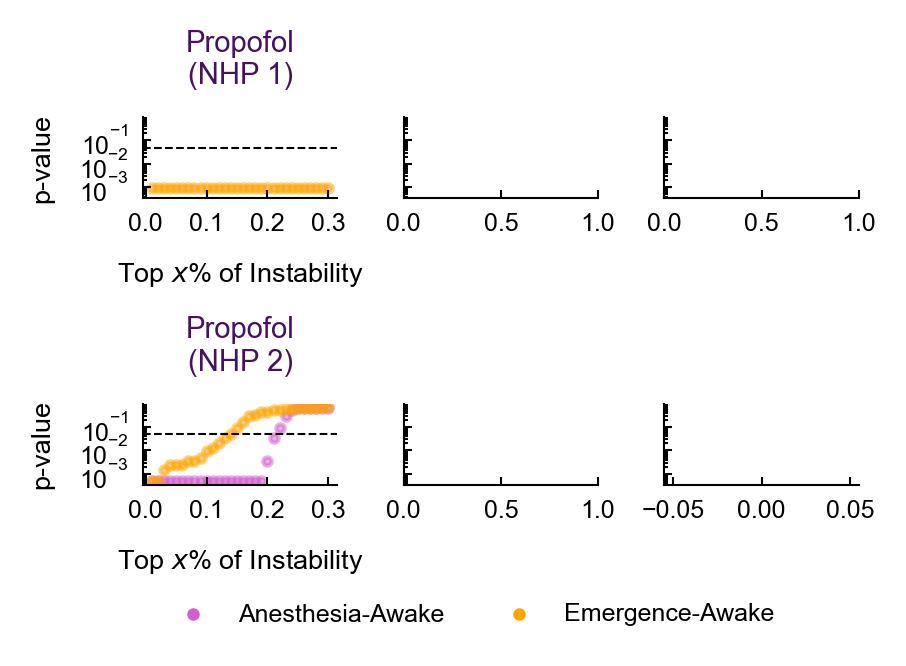

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(3, 2), sharey=True)

max_top_percent = 0.3
plot_top_percents = np.array(top_percents)[np.array(top_percents) <= max_top_percent]

for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    for j, monkey in enumerate(all_section_means[(data_class, agent)]):
        ax = axs[j, i]
        wp_vals_anesthesia_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] for top_percent in plot_top_percents]
        wp_vals_emergence_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] for top_percent in plot_top_percents]
        ax.scatter(plot_top_percents, wp_vals_anesthesia_awake, color=cfg.plotting.epoch_colors['anesthesia'], alpha=0.5)
        ax.scatter(plot_top_percents, wp_vals_emergence_awake, color=cfg.plotting.epoch_colors['emergence'], alpha=0.5)
        ax.axhline(y=0.05, color='black', linestyle='--')
        ax.set_yscale('log')
        NHP_num = j+1 if agent == 'propofol' else j+3
        ax.set_title(f"{agent.capitalize()}\n(NHP {NHP_num})", color=cfg.plotting.curve_colors[agent], fontsize=7)
        ax.set_xlabel(f'Top $x$% of Instability')
        ax.set_xticks([0, 0.1, 0.2, 0.3])
        if i == 0:
            ax.set_ylabel(f'p-value')
anes_pts = plt.scatter([], [], label='Anesthesia-Awake', color=cfg.plotting.epoch_colors['anesthesia'])
emerg_pts = plt.scatter([], [], label='Emergence-Awake', color=cfg.plotting.epoch_colors['emergence'])

# put legend under figure centered
fig.legend(ncol=2, bbox_to_anchor=(0.52, -0.02), loc='center')
plt.tight_layout()
plt.show()


# Distribution of stability parameters

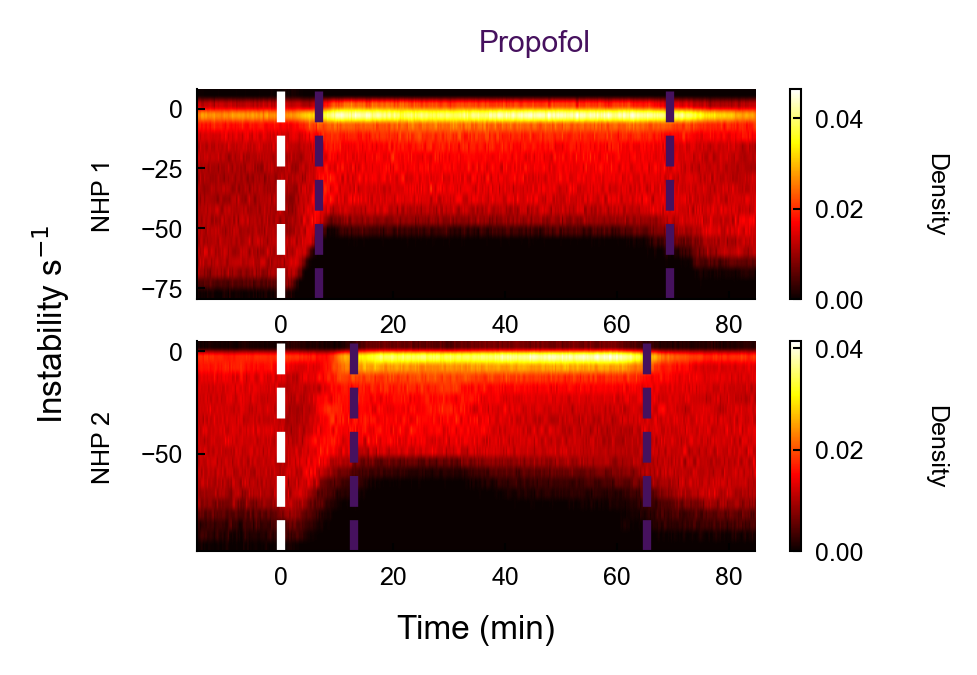

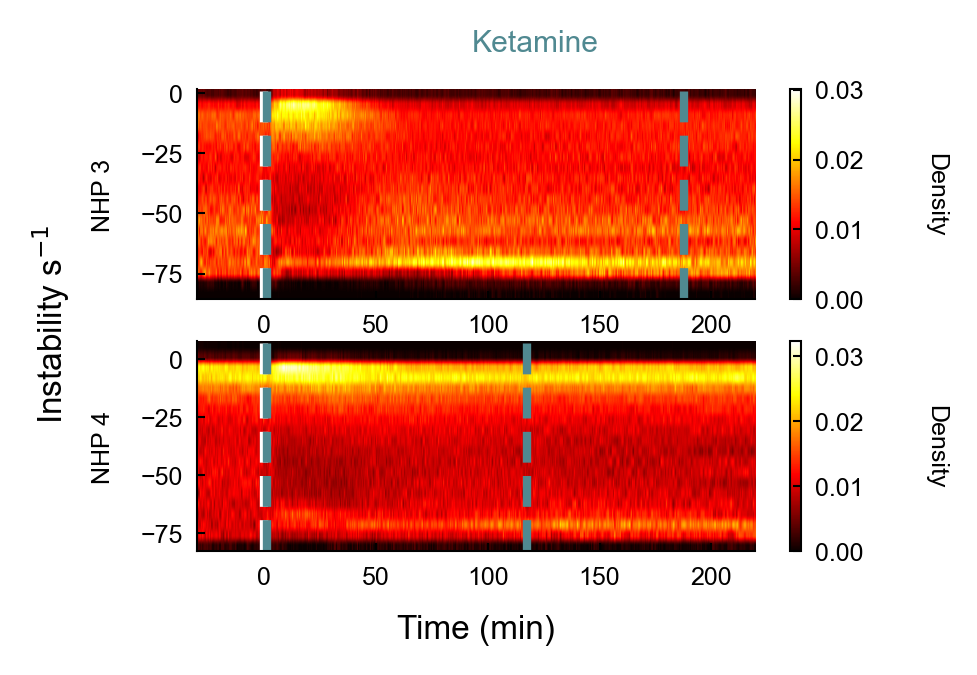

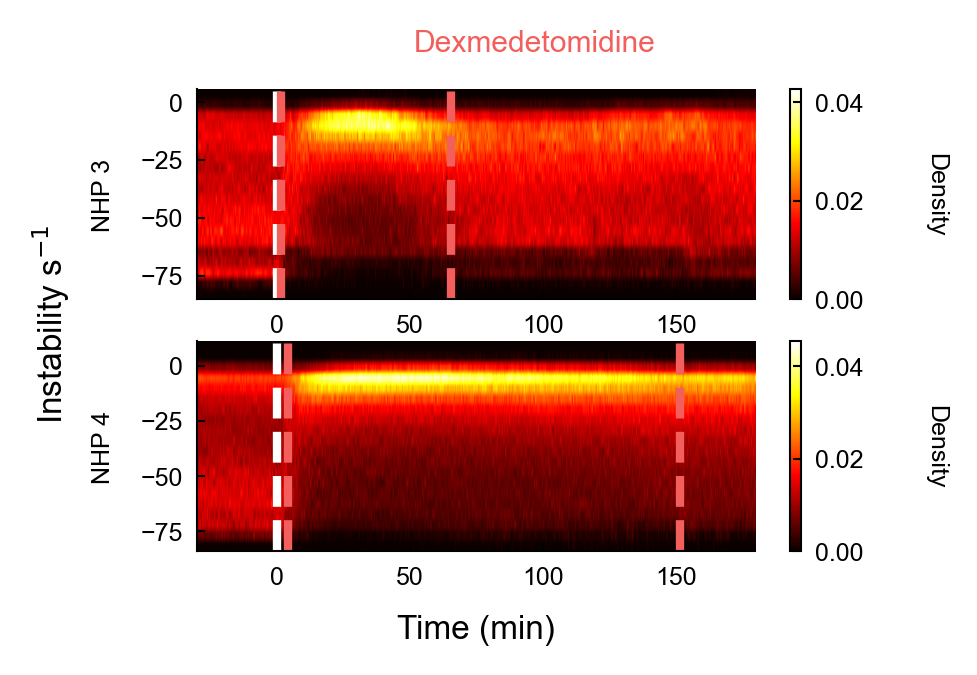

In [ ]:
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    cfg.params.data_class = data_class
    common_times = np.arange(plot_range[0], plot_range[1], 1/4)
    all_interpolated_stability_params = {
        monkey: np.zeros((len(common_times), 0)) for monkey in agent_data[(data_class, agent)]['session_lists']
    }
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            if 'propofol' in agent:
                is_lever = False
            else:
                is_lever = True
            if is_lever:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['infusionStart'][0, 0]
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['drugStart'][0]


            time_vals = (df.window_start.values - infusion_time) / 60
            num_eigs = df.stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).min()
            stability_params = np.vstack(df.stability_params.apply(lambda x: x[:num_eigs]).to_numpy())
            interpolated_stability_params = np.zeros((len(common_times), stability_params.shape[-1]))
            for i in range (stability_params.shape[-1]):
                interpolated_stability_params[:, i] = np.interp(common_times, time_vals, stability_params[:, i])
            all_interpolated_stability_params[monkey] = np.concatenate((all_interpolated_stability_params[monkey], interpolated_stability_params), axis=1)
    
    fig, axs = plt.subplots(2, 1, figsize=(3, 2))

    for i, monkey in enumerate(all_interpolated_stability_params):
        ax = axs[i]
        # 1. Find the global min and max of the stability parameters to define bin edges.
        min_val = np.min(all_interpolated_stability_params[monkey])
        max_val = np.max(all_interpolated_stability_params[monkey])

        # 2. Construct 20 histogram bins between the min and max values.
        num_bins = 20
        bins = np.linspace(min_val, max_val, num_bins + 1)

        # 3. Initialize an array to hold the histogram data for each time point.
        # The shape will be (number of time points, number of bins).
        histogram_data = np.zeros((len(common_times), num_bins))

        # 4. For each time point, compute the histogram of stability parameters.
        for t in range(len(common_times)):
            # Get all stability parameters at the current time point.
            params_at_t = all_interpolated_stability_params[monkey][t, :]
            # Compute the histogram. 'density=True' normalizes it to form a probability density.
            hist, _ = np.histogram(params_at_t, bins=bins, density=True)
            histogram_data[t, :] = hist

        # Use imshow to create the heatmap.
        # - Transpose histogram_data (.T) so time is on the x-axis.
        # - aspect='auto' allows the heatmap to fill the plot area.
        # - origin='lower' places the (0,0) index at the bottom-left.
        # - extent sets the coordinates of the heatmap image.
        # - cmap='hot' matches the color scheme of your example image.
        im = ax.imshow(
            histogram_data.T,
            aspect='auto',
            origin='lower',
            extent=[common_times[0], common_times[-1], min_val, max_val],
            cmap='hot'
        )

        # 6. Add a colorbar and axis labels.
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Density', rotation=270, labelpad=20, fontsize=6)
        ax.set_xlabel('Time (min)', fontsize=8)
        if is_lever:
            ax.set_ylabel(f'NHP {i+3}', fontsize=6)
        else:
            ax.set_ylabel(f'NHP {i+1}', fontsize=6)

        # 7. Set the y-axis ticks and limits to match your example plot.
        # The values are taken directly from the image you provided.
        # y_ticks_values = [-70.2, -53.8, -37.5, -21.2, -4.9, 11.4]
        # ax.set_yticks(y_ticks_values)
        # ax.set_ylim(bottom=y_ticks_values[0], top=y_ticks_values[-1])
        ax.tick_params(axis='both', which='major', labelsize=6)

        # 8. (Optional) Add vertical lines for specific events if you have the times.
        # The colors are chosen to approximate those in your image.
        # Replace the placeholder values (e.g., 2, 8, 60, 75) with your actual event times.
        ax.axvline(x=0, color='white', linestyle='--', linewidth=2)  # Pinkish
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['locs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['rocs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
    # add text to the left indicating the y axis is "Instability s^{-1}"
    ax.text(-0.3, 0.65, r'Instability s$^{-1}$', rotation=90, fontsize=8, transform=ax.transAxes)
    plt.suptitle(f"{agent.capitalize()}", color=cfg.plotting.curve_colors[agent])
    plt.savefig(os.path.join(img_save_dir, f"{agent}_stability_heatmap.pdf"), transparent=True, bbox_inches='tight')
    plt.show()

# Hyperparameter combos

In [127]:
for (data_class, agent) in anesthetic_agent_list:
    cfg.params.data_class = data_class
    session_list = agent_data[(data_class, agent)]['session_list']
    session_list = [session_list[-1]]
    session = session_list[0]
    section_info, _, _, _ = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    areas = ['all']
    pca_chosen = None
    verbose = False
    grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen, verbose=verbose)
    print(f"Number of models fit for {agent}: {(~np.isnan(grid_search_results[session]['all']['mats']['aic']))[0].sum()} ({grid_search_results[session]['all']['mats']['aic'].shape[0]} windows)")


Number of models fit for propofol: 814 (20 windows)
Number of models fit for ketamine: 630 (32 windows)
Number of models fit for dexmedetomidine: 654 (32 windows)
